
# Dialect classification

### Install and import necessary packages

In [ ]:
!pip install transformers seqeval[gpu]
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.2 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 6.6 MB 42.8 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 83.7 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=4910707b56b9dbd3231a85e54955475bc2df6b28586f1949eced4522b703e8ab
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 4.2 MB/s 
     |███████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.2 MB/s 


In [ ]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import datasets
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load data

#### import data

In [ ]:
torch.cuda.is_available()
device = torch.device("cuda")
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive'
train_path = '/content/drive/MyDrive/train_data.csv'
dev_path = '/content/drive/MyDrive/test_data.txt'

Mounted at /content/drive
'Colab Notebooks'	 test_data.txt	     train_features.csv
 pretrain_features.csv	 test_features.csv   train_labels.csv
 pretrain_labels.csv	 train_data.csv


In [ ]:
#IMPORT devset
dial_label = {
    0 : 'EML',
    1 : 'NAP',
    2 : 'PMS',
    3 : 'FUR',
    4 : 'LLD',
    5 : 'LIJ',
    6 : 'LMO',
    7 : 'ROA_TARA',
    8 : 'SCN', 
    9 : 'VEC',
    10 : 'SC'
}

fold_label = {
    'EML' : 0,
    'NAP' : 1,
    'PMS' : 2,
    'FUR' : 3,
    'LLD' : 4,
    'LIJ' : 5,
    'LMO' : 6,
    'ROA_TARA' : 7,
    'SCN' : 8,
    'VEC' : 9,
    'SC' : 10
}

def explain_label(label : int) -> str:
    """ 
    Given an integer label, convert it to the corresponding string label
    :param int label: integer label to be converted
    :return: string corresponding to the given label
    """
    return dial_label[label]

def encode_label(label : str) -> int:
    """ 
    Given a string label, encode it to the corresponding index
    :param string label: string label to be converted
    :return: int corresponding to the given label
    """
    return fold_label[label]

In [ ]:
df_dev = pd.read_csv(dev_path, sep = "\t", names=["label", "text"])
df_dev['label'] = df_dev['label'].apply(encode_label)
df_dev = df_dev.fillna('')
#-
df_train = pd.read_csv(train_path)
df_train_=df_train[['text','label']]
df_train_.drop_duplicates(subset ='text',keep = False, inplace = True, ignore_index=True) 
#SUBSET
#f_train_ = df_train_.iloc[0:1000,:] 

In [ ]:
# Create dictionaries to transform from labels to id and vice-versa.
id2label = {0 : 'EML',
    1 : 'NAP',
    2 : 'PMS',
    3 : 'FUR',
    4 : 'LLD',
    5 : 'LIJ',
    6 : 'LMO',
    7 : 'ROA_TARA',
    8 : 'SCN', 
    9 : 'VEC',
    10 : 'SC'}
label2id = {v:k for k,v in id2label.items()}
num_labels = len(id2label)
print(id2label)

{0: 'EML', 1: 'NAP', 2: 'PMS', 3: 'FUR', 4: 'LLD', 5: 'LIJ', 6: 'LMO', 7: 'ROA_TARA', 8: 'SCN', 9: 'VEC', 10: 'SC'}


In [ ]:
from datasets import Dataset
train_ds = Dataset.from_pandas(df_train_)
dev_ds = Dataset.from_pandas(df_dev)
# Example of instance of the dataset
train_ds[18]

{'label': 0,
 'text': "Una gita scolastica  all'è un film dal 1983 dirigì da Pupi Avati."}

## Tokenizing data

In [ ]:
# Load XLNet tokenizer.
model_name = 'm-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

In [ ]:

def encode_dataset(dataset: datasets.arrow_dataset.Dataset) -> list:
  '''
  Transforming each instance of the dataset with the Tokenizer
  '''
  encoded_dataset = []
  for item in dataset:
    # Tokenize the sentence.
    sentence_encoded = tokenizer(item['text'],
                                return_tensors="pt", 
                                padding='max_length', 
                                truncation=True, 
                                max_length=50)
    
    sentence_encoded['labels'] = torch.LongTensor(np.array([item['label']]))
    encoded_dataset.append(sentence_encoded)

  # Reduce dimensionality of tensors.
  for item in encoded_dataset:
    for key in item:
      item[key] = torch.squeeze(item[key])
  return encoded_dataset

In [ ]:
# Tokenizing datasets
encoded_dataset_train = encode_dataset(train_ds)
encoded_dataset_test = encode_dataset(dev_ds)

## Data EDA

# Fine tunning of the model

In [ ]:
# Common training arguments
training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_dir='logs',
    no_cuda=False,  
    output_dir = 'drive/MyDrive/',
)

# Dictionary to save the results
models_performance ={}

# FINE TUNING PROCESS

# create model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Create trainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=encoded_dataset_train,)

# Fine tunning
trainer.train()

Downloading:   0%|          | 0.00/706M [00:00<?, ?B/s]

Some weights of the model checkpoint at m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were

Step,Training Loss
500,0.300900
1000,0.145700
1500,0.121600
2000,0.105700
2500,0.092600
3000,0.085700


Saving model checkpoint to drive/MyDrive/checkpoint-500
Configuration saved in drive/MyDrive/checkpoint-500/config.json
Model weights saved in drive/MyDrive/checkpoint-500/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/checkpoint-500/tokenizer_config.json
Special tokens file saved in drive/MyDrive/checkpoint-500/special_tokens_map.json
Saving model checkpoint to drive/MyDrive/checkpoint-1000
Configuration saved in drive/MyDrive/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/checkpoint-1000/tokenizer_config.json
Special tokens file saved in drive/MyDrive/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to drive/MyDrive/checkpoint-1500
Configuration saved in drive/MyDrive/checkpoint-1500/config.json
Model weights saved in drive/MyDrive/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/checkpoint-1500/tokenizer_config.json
Special tok

TrainOutput(global_step=3038, training_loss=0.14137605729269465, metrics={'train_runtime': 3287.867, 'train_samples_per_second': 118.247, 'train_steps_per_second': 0.924, 'total_flos': 9990316914849300.0, 'train_loss': 0.14137605729269465, 'epoch': 1.0})

In [ ]:
# Get the predicted labels
preds = trainer.predict(encoded_dataset_test)
predictions = preds.predictions.argmax(-1)

# Create array with predicted labels and expected.
true_values = np.array(preds.label_ids).flatten()
predicted_values = np.array(preds.predictions.argmax(-1)).flatten()

# Filter the labels. We only produce a label for each word. We filter labels
# of subwords and special tokens, such as PAD
proc_predicted_values = [prediction for prediction, label in zip(predicted_values, true_values) if label != -100]
proc_true_values = [label for prediction, label in zip(predicted_values, true_values) if label != -100]

# Evaluate models
model_performance = {}
model_performance['accuracy'] = accuracy_score(proc_true_values, proc_predicted_values)
model_performance['precision_micro'] = precision_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['precision_macro'] = precision_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['recall_micro'] = recall_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['recall_macro'] = recall_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['f1_micro'] = f1_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['f1_macro'] = f1_score(proc_true_values, proc_predicted_values, average='macro')

model_performance['confusion_matrix'] = confusion_matrix(proc_true_values, proc_predicted_values)
model_performance['confusion_matrix_normalized'] = confusion_matrix(proc_true_values, proc_predicted_values, normalize='true')

***** Running Prediction *****
  Num examples = 6801
  Batch size = 128


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.DataFrame(proc_predicted_values).to_csv("drive/MyDrive/predictions", header=False, index=False)

In [ ]:
wrong = []
for i,x in enumerate(df_dev["text"]):
  if df_dev["label"].iloc[i] != proc_predicted_values[i]:
    wrong.append(i)

In [ ]:
pd.DataFrame(wrong).to_csv("drive/MyDrive/wrong.csv", index=False, header=False)

# Models evaluation

F1-micro and F1-macro for each model

In [ ]:
print('------------Model performance------------')
print(f'  accuracy: {model_performance["accuracy"]}')
print(f'  f1-micro: {model_performance["f1_micro"]}')
print(f'  f1-macro: {model_performance["f1_macro"]}')
print()

------------Model performance------------
  accuracy: 0.8769298632554036
  f1-micro: 0.8769298632554036
  f1-macro: 0.5627176804812641



To understan better the performance of the classifier, we display the confusion matrix:

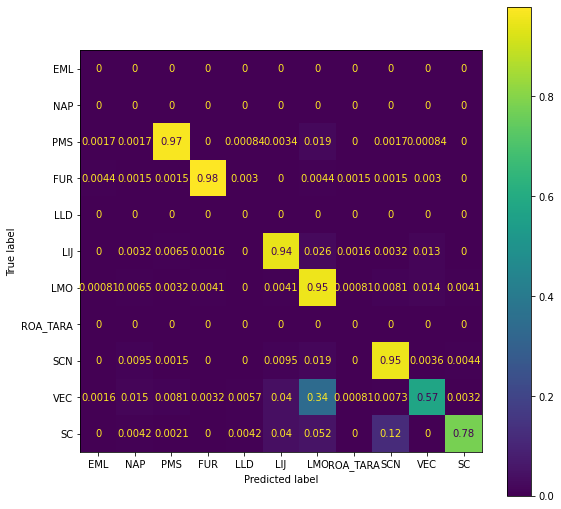

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix_normalized'], display_labels = list(id2label.values()))
fig, ax = plt.subplots(figsize=(9,9))
disp.plot(ax=ax)

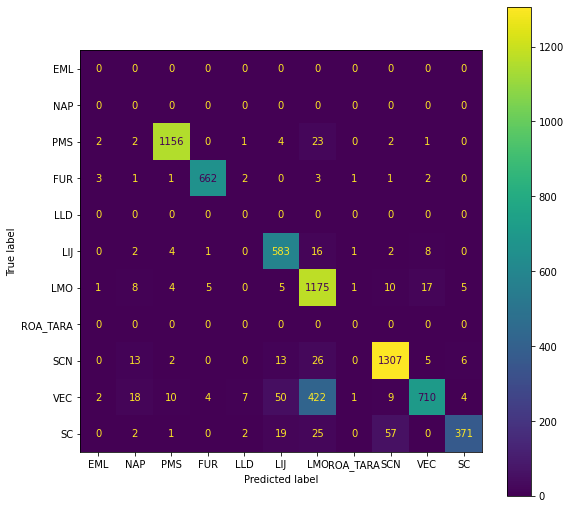

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix'],display_labels = list(id2label.values()))
fig, ax = plt.subplots(figsize=(9,9))
disp.plot(ax=ax)

In [ ]:
np.array(df_dev["label"])

array([6, 8, 6, ..., 8, 8, 8])

In [ ]:
np.array(pd.read_csv("drive/MyDrive/predictions"))

array([[8],
       [6],
       [9],
       ...,
       [8],
       [8],
       [8]])

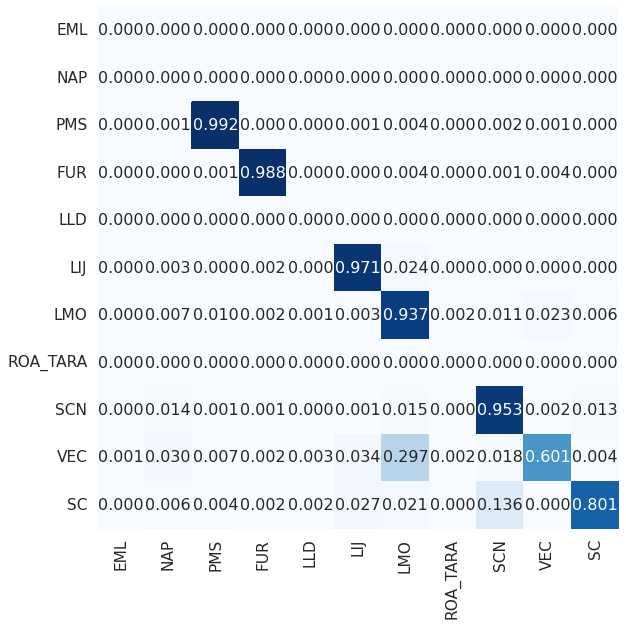

In [ ]:
cm = confusion_matrix(y_true=np.array(df_dev["label"])[1:], y_pred=np.array(pd.read_csv("drive/MyDrive/predictions")), normalize="true", labels=range(0,11))

df_cm = pd.DataFrame(cm, index = [explain_label(i) for i in range(0,11)],
                  columns = [explain_label(i) for i in range(0,11)])

plt.figure(figsize = (9, 9))
sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, 
            annot=True, 
            annot_kws={"size": 16}, 
            fmt='.3f', 
            cmap="Blues",
            cbar=False) 
plt.tight_layout()  

# plt.savefig('confusion.pdf')
plt.show()

